In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_dataset.classes

In [ ]:
from torch.utils.data import Subset

selected_classes = ['tiger', 'woman', 'dinosaur', 'cattle', 'cloud', 'worm', 'cup', 'wolf', 'palm_tree', 'flatfish',
                    'can', 'rose', 'couch', 'snake', 'sea', 'streetcar', 'baby', 'road', 'house', 'motorcycle']

class_to_idx = {class_name: i for i, class_name in enumerate(selected_classes)}

original_to_new_indices = {train_dataset.class_to_idx[name]: class_to_idx[name] for name in selected_classes}

def filter_and_remap(dataset):
    indices_to_keep = [i for i, (_, label) in enumerate(dataset) if label in original_to_new_indices]
    new_labels = [original_to_new_indices[label] for (_, label) in dataset if label in original_to_new_indices]
    subset = Subset(dataset, indices_to_keep)
    for i, (_, label) in enumerate(subset):
        subset.dataset.targets[indices_to_keep[i]] = new_labels[i]
    return subset

train_set = filter_and_remap(train_dataset)
test_set = filter_and_remap(test_dataset)

In [ ]:
print(f"Number of samples in the filtered datasets: {len(train_set), len(test_set)}")

Number of samples in the filtered datasets: (10000, 2000)


In [ ]:
print(class_to_idx)

{'tiger': 0, 'woman': 1, 'dinosaur': 2, 'cattle': 3, 'cloud': 4, 'worm': 5, 'cup': 6, 'wolf': 7, 'palm_tree': 8, 'flatfish': 9, 'can': 10, 'rose': 11, 'couch': 12, 'snake': 13, 'sea': 14, 'streetcar': 15, 'baby': 16, 'road': 17, 'house': 18, 'motorcycle': 19}


In [ ]:
calib_size = int(0.05 * len(train_set))
remaining_size = len(train_set) - calib_size

calib_set, train_set = random_split(train_set, [calib_size, remaining_size])

print(len(calib_set))


500


In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
calibration_loader = DataLoader(calib_set, batch_size=32, shuffle=True)

In [ ]:
model = models.efficientnet_b0().to(device)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=20)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer, accuracy_function):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss.item()
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))

In [ ]:
for epoch in range(10):
  loss, acc = train_function(model, device, train_loader, loss_fn, optimizer, accuracy_function)
  print(f'epoch: {epoch+1} | loss: {loss:.4f} | accuracy: {acc:.4f}%')

  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 1 | loss: 0.6019 | accuracy: 79.7694%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 2 | loss: 0.5757 | accuracy: 80.2775%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 3 | loss: 0.5206 | accuracy: 82.2135%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 4 | loss: 0.4822 | accuracy: 83.4205%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 5 | loss: 0.4279 | accuracy: 85.3791%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 6 | loss: 0.4097 | accuracy: 85.9999%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 7 | loss: 0.3844 | accuracy: 86.9649%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 8 | loss: 0.3901 | accuracy: 86.7785%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 9 | loss: 0.3504 | accuracy: 88.5823%


  0%|          | 0/297 [00:00<?, ?it/s]

epoch: 10 | loss: 0.4001 | accuracy: 86.5515%


In [ ]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
print(len(test_set), len(test_loader))

2000 63


In [ ]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calibration_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [ ]:
n = len(calib_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.9992063

In [ ]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_set)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_set, selected_indices)

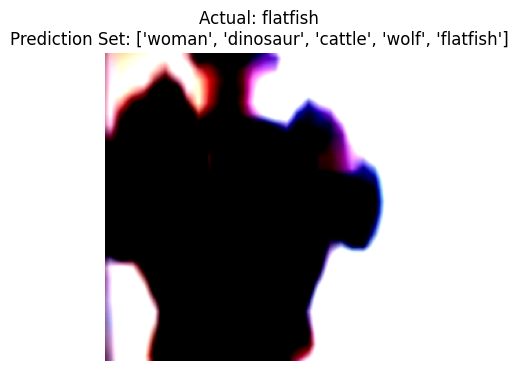

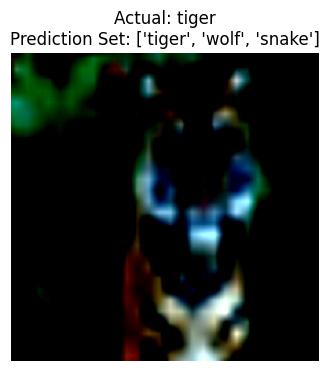

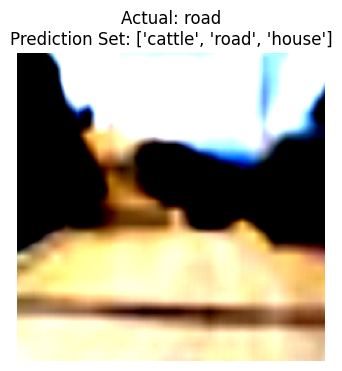

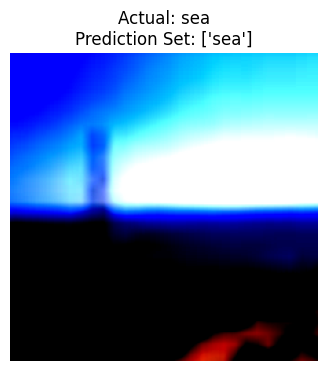

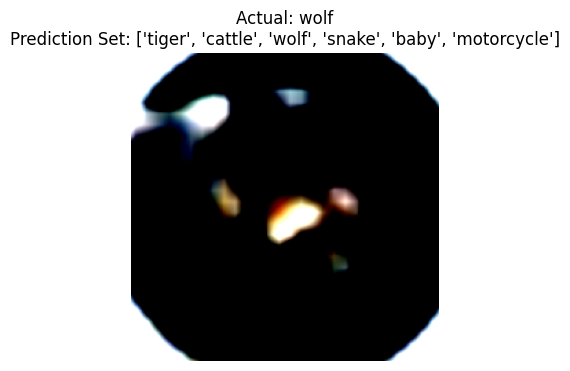

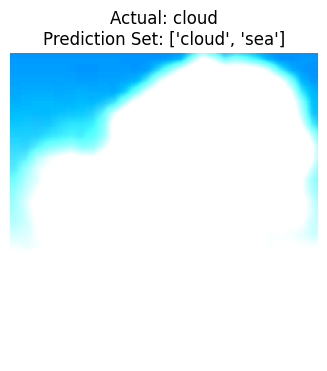

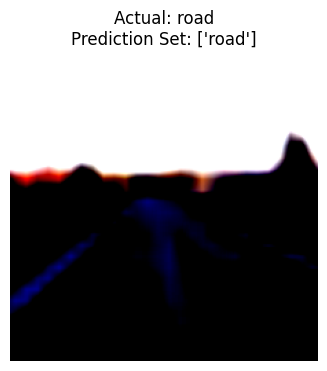

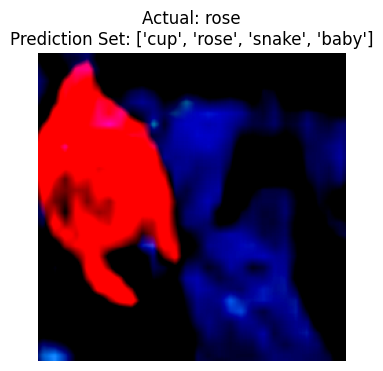

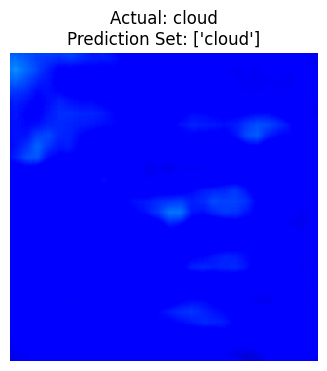

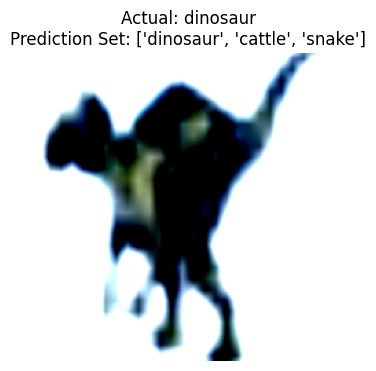

In [ ]:
import matplotlib.pyplot as plt

prediction_sets = []
class_names = selected_classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().permute(1,2,0))
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
from google.colab import files
files.download('model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>